In [2]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using ForwardDiff
using Plots
using LinearAlgebra
using StaticArrays
using Base.Threads

In [ ]:
nthreads()

In [ ]:
function get_barnesgrad()
    a1 = 75.196
    a3 = 0.12694
    a5 = 1.0345e-5
    a7 = 0.030234
    a9 = 3.5256e-5
    a11 = 0.25645
    a13 = 1.3514e-5
    a15 = -5.2375e-6
    a17 = 7.0e-10
    a19 = -1.6638e-6
    a21 = 0.0005
    a2 = -3.8112
    a4 = -2.0567e-3
    a6 = -6.8306
    a8 = -1.28134e-3
    a10 = -2.266e-7
    a12 = -3.4604e-3
    a14 = -28.106
    a16 = -6.3e-8
    a18 = 3.4054e-4
    a20 = -2.8673
    
    function eval_obj(x::AbstractArray{T}) where T
        x1 = x[1]
        x2 = x[2]
        y1 = x1*x2
        y2 = y1*x1
        y3 = x2^2
        y4 = x1^2

        f = a1 + a2*x1 + a3*y4 + a4*y4*x1 + a5*y4^2 +
            a6*x2 + a7*y1 + a8*x1*y1 + a9*y1*y4 + a10*y2*y4 +
            a11*y3 + a12*x2*y3 + a13*y3^2 + a14/(x2+1) +
            a15*y3*y4 + a16*y1*y4*x2 + a17*y1*y3*y4 + a18*x1*y3 +
            a19*y1*y3 + a20*exp(a21*y1)
        
        f
    end

    function eval_cons(x::AbstractArray{T}) where T
        x1 = x[1]
        x2 = x[2]
        y1 = x1*x2
        y2 = y1*x1
        y3 = x2^2
        y4 = x1^2
        
        c = zeros(T, 3)
        c[1] = 1 - y1/700.0
        c[2] = y4/25.0^2 - x2/5.0
        c[3] = (x1/500.0- 0.11) - (x2/50.0-1)^2
        
        c
    end
    
    fres = DiffResults.GradientResult(zeros(2))
    fcfg = ForwardDiff.GradientConfig(eval_obj, zeros(2))
    gres = DiffResults.JacobianResult(zeros(3), zeros(2))
    gcfg = ForwardDiff.JacobianConfig(eval_cons, zeros(2))
    function solver_fn(x)
        ForwardDiff.gradient!(fres, eval_obj, x, fcfg)
    
        J = eval_obj(x)
        gJ = ForwardDiff.gradient(eval_obj, x)
        
        HJ = ForwardDiff.hessian(eval_obj, x)
        
        ForwardDiff.jacobian!(gres, eval_cons, x, gcfg)
    
        g = DiffResults.value(gres)
        ceq = zeros(0)
        c = g
    
        dgdx = DiffResults.jacobian(gres)
        gceq = zeros(0,2)
        gc = dgdx
    
        J, ceq, c, gJ, gceq, gc, HJ
    end
    
    solver_fn
end

solver_fn = get_barnesgrad()

x0 = [10.0, 10.0]
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = 1
xopt, info = Bilevel.snopt(solver_fn, 0, 3, x0, options)

display(info)
display(xopt)
display(isapprox(xopt[1], 49.5263; atol=1e-4))
display(isapprox(xopt[2], 19.6228; atol=1e-4))

x0 = [10.0, 10.0]
options = Dict{String, Any}()
options["num_fosteps"] = 0
options["num_sosteps"] = 10
options["c"] = 100.
options["c_fos"] = 1.
options["c_sos"] = 5.
xopt, info = Bilevel.auglag(solver_fn, 0, 3, x0, options)

display(info)
display(xopt)
display(isapprox(xopt[1], 49.5263; atol=1e-4))
display(isapprox(xopt[2], 19.6228; atol=1e-4))

In [3]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, .5)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)
ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
Δt = .01

0.01

In [ ]:
q1 = [1., 0., 0., 0., 0., 0., 0.017]
v1 = [0., 0., 0., 1., 0., 0.]
N = 25

In [ ]:
sim_data_indirect = get_sim_data_indirect(mechanism,env,Δt,relax_comp=false)
set_configuration!(x0, q1)
set_velocity!(x0, v1)
traj_indirect = Bilevel.simulate(sim_data_indirect, ctrl!, x0, N, verbose=1)

In [ ]:
sim_data_direct = get_sim_data_direct(mechanism,env,Δt,relax_comp=false)
set_configuration!(x0, q1)
set_velocity!(x0, v1)
traj_direct = Bilevel.simulate(sim_data_direct, ctrl!, x0, N, verbose=1)

In [ ]:
j = 7
clibrary(:Plots)
gr(size=(800,500), html_output_format=:png, 
    seriescolor=:magma,  background_color_legend=:white, 
    background=RGB(((240,240,240) ./ 255.)...));
plot(traj_indirect[6],traj_indirect[7][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)
plot!(traj_direct[6],traj_direct[7][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)

In [4]:
q1 = [1., 0., 0., 0., 0., 0., 0.]
qN = [1., 0., 0., 0., .1, 0., 0.]
N = 10
Δt = .01

0.01

In [14]:
sim_data_indirect = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)

# adding user defined constraint
vs = sim_data_indirect.vs

add_eq!(sim_data_indirect, :cq1, length(q1), x -> vs(x, :q1) - q1)
add_eq!(sim_data_indirect, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)

add_box_con!(sim_data_indirect, :u, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)
add_box_con!(sim_data_indirect, :hbox, :h, [.005], [.01], 1:N-1)

for i=1:N
    add_ineq!(sim_data_indirect, Symbol("height",i), 1, x -> vs(x, Symbol("q",i))[7] - .001)
end

for i=1:N-1
    add_obj!(sim_data_indirect, Symbol("v",i), x -> vs(x, Symbol("h",i))[1]*vs(x, Symbol("v",i))'*vs(x, Symbol("v",i)))
end
add_obj!(sim_data_indirect, Symbol("v",N), x -> vs(x, Symbol("v",N))'*vs(x, Symbol("v",N)))

10-element Array{Tuple{Symbol,Any},1}:
 (:v1, getfield(Main, Symbol("##33#34")){Int64}(1))
 (:v2, getfield(Main, Symbol("##33#34")){Int64}(2))
 (:v3, getfield(Main, Symbol("##33#34")){Int64}(3))
 (:v4, getfield(Main, Symbol("##33#34")){Int64}(4))
 (:v5, getfield(Main, Symbol("##33#34")){Int64}(5))
 (:v6, getfield(Main, Symbol("##33#34")){Int64}(6))
 (:v7, getfield(Main, Symbol("##33#34")){Int64}(7))
 (:v8, getfield(Main, Symbol("##33#34")){Int64}(8))
 (:v9, getfield(Main, Symbol("##33#34")){Int64}(9))
 (:v10, getfield(Main, Symbol("##35#36"))())       

In [15]:
traj_indirect = Bilevel.trajopt(sim_data_indirect, quaternion_state=true, verbose=1)

Finished successfully: optimality conditions satisfied


(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 5.06336e-12, -4.55018e-5, 6.80215e-13, 0.0125784, -1.44622e-14, 0.0009905], [1.0, 2.4872e-12, -9.14452e-5, 6.96916e-13, 0.0251566, -1.03396e-15, 0.001], [1.0, 2.47308e-12, -0.000234415, 6.93925e-13, 0.0377346, -7.76916e-15, 2.85001e-5], [1.0, 2.3972e-12, -0.000152481, -1.79747e-14, 0.0493503, -2.48435e-15, 3.71554e-22], [1.0, 6.47497e-17, -7.06055e-5, 2.91398e-14, 0.0604613, -1.18225e-16, 0.0], [1.0, -9.54564e-18, -5.99726e-5, 2.10705e-14, 0.0710817, -7.84851e-17, -5.50763e-14], [1.0, -8.38247e-17, -3.6679e-5, 1.47651e-14, 0.0812117, -4.49554e-17, -6.77626e-21], [1.0, -4.19125e-17, -4.20901e-7, 1.46377e-14, 0.0908511, -1.93365e-17, 8.4159e-14], [1.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0]], Array{Float64,1}[[2.22367e-10, -0.00910293, 5.18789e-12, 1.25784, 7.78507e-13, 0.19715], [1.02251e-9, -0.00910036, 1.44521e-10, 1.25784, -1.01902e-12, 0.0989355], [-5.64829e-10, -0.00918868, 8.17006e-15, 1.25783, -1.48782e-12, 0.000719954], [-4.330

In [ ]:
sim_data_direct = get_trajopt_data_direct(mechanism,env,Δt,N,relax_comp=false)

# adding user defined constraint
vs = sim_data_direct.vs

add_eq!(sim_data_direct, :cq1, length(q1), x -> vs(x, :q1) - q1)
add_eq!(sim_data_direct, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)

add_box_con!(sim_data_direct, :u, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)
add_box_con!(sim_data_direct, :hbox, :h, [.005], [.01], 1:N-1)

for i=1:N
    add_ineq!(sim_data_direct, Symbol("height",i), 1, x -> vs(x, Symbol("q",i))[7] - .001)
end

# for i=1:N-1
#     add_obj!(sim_data_direct, Symbol("v",i), x -> vs(x, Symbol("h",i))[1]*vs(x, Symbol("v",i))'*vs(x, Symbol("v",i)))
# end
# add_obj!(sim_data_direct, Symbol("v",N), x -> vs(x, Symbol("v",N))'*vs(x, Symbol("v",N)));

In [ ]:
traj_direct = Bilevel.trajopt(sim_data_direct, quaternion_state=true, verbose=1)

In [31]:
sim_data_semidirect = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)

# adding user defined constraint
vs = sim_data_semidirect.vs

add_eq!(sim_data_semidirect, :cq1, length(q1), x -> vs(x, :q1) - q1)
add_eq!(sim_data_semidirect, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)

add_box_con!(sim_data_semidirect, :u, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)
add_box_con!(sim_data_semidirect, :hbox, :h, [.005], [.01], 1:N-1)

for i=1:N
    add_ineq!(sim_data_semidirect, Symbol("height",i), 1, x -> vs(x, Symbol("q",i))[7] - .001)
end

for i=1:N-1
    add_obj!(sim_data_semidirect, Symbol("v",i), x -> vs(x, Symbol("h",i))[1]*vs(x, Symbol("v",i))'*vs(x, Symbol("v",i)))
#     add_obj!(sim_data_semidirect, Symbol("q",i), x -> vs(x, Symbol("q",i))[7])
end
add_obj!(sim_data_semidirect, Symbol("v",N), x -> vs(x, Symbol("v",N))'*vs(x, Symbol("v",N)));

In [32]:
traj_semidirect = Bilevel.trajopt(sim_data_semidirect, quaternion_state=true, verbose=1)

The problem appears to be infeasible: nonlinear infeasibilities minimized


(Any[[1.0, 0.0, 0.0, 0.0, 0.0, 2.09147e-13, 0.0], [1.0, 0.0, 1.13941e-5, 0.0, 0.0192824, 1.4609e-13, 0.0], [1.0, 0.0, 1.56814e-5, 0.0, 0.0380743, 1.2032e-13, 0.0], [1.0, 0.0, 1.88084e-5, 0.0, 0.0469209, 9.97168e-14, 0.000853625], [1.0, 0.0, 2.0048e-5, 0.0, 0.0557674, 1.03867e-13, 0.000636875], [1.0, 0.0, 2.0048e-5, 0.0, 0.0646139, 5.2248e-14, 0.001], [1.0, 0.0, 1.68582e-5, 0.0, 0.0734604, 3.17113e-14, 0.00111787], [1.0, 0.0, 9.30355e-6, 0.0, 0.082307, -2.01535e-15, 0.0009905], [1.0, 0.0, 1.65314e-6, 0.0, 0.0911535, 0.0, 0.000617875], [1.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0]], Any[[0.0, 0.0, 0.0, 1.92824, 5.25412e-13, 0.0981], [0.0, 0.00227883, 0.0, 1.92824, 2.61121e-13, 4.39413e-5], [0.0, 0.000857458, 0.0, 1.87919, 4.18895e-13, 5.89369e-5], [0.0, 0.00125077, 0.0, 1.7693, 6.93433e-13, 0.170792], [0.0, 0.000495864, 0.0, 1.7693, 5.46135e-13, 0.121746], [0.0, 0.0, 0.0, 1.7693, 4.3571e-13, 0.0726959], [0.0, -0.00127593, 0.0, 1.7693, 2.38419e-14, 0.0236347], [0.0, -0.00302187, 0.0, 1.7693, 8.1103

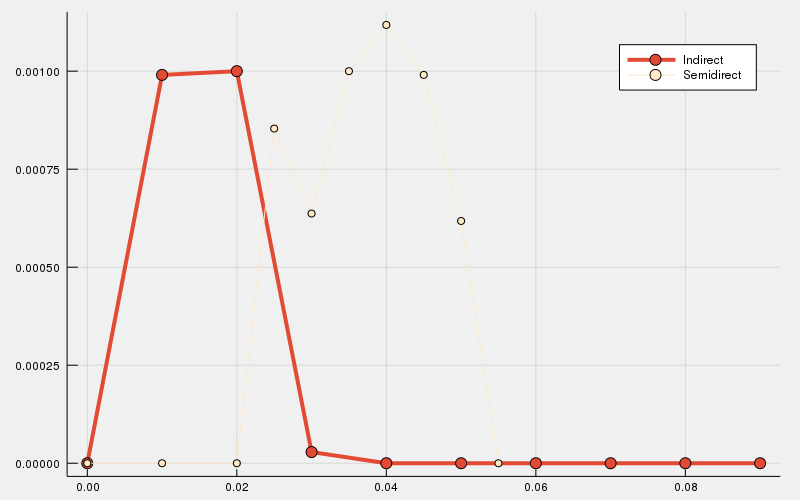

In [33]:
j = 7
clibrary(:Plots)
gr(size=(800,500), html_output_format=:png, 
    seriescolor=:magma,  background_color_legend=:white, 
    background=RGB(((240,240,240) ./ 255.)...));
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)
# plot!(traj_direct[7],traj_direct[8][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)